# A new model for CMAP prediction

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import h5py
import tqdm

%load_ext autoreload
%autoreload 2

/net/scratch3.mit.edu/scratch3-3/kdevko01/conda/.conda/envs/main/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [16]:
class Model(nn.Module):
    def __init__(self, init_dim, project_dim, n_head_within, n_bins, ppi_window = 10, drop = 0.2, activation = "tanh"):
        super(Model, self).__init__()
        # activations allowed
        activations = {"sigmoid" : nn.Sigmoid(), "tanh" : nn.Tanh(), "relu" : nn.ReLU()}
        self.project = nn.Linear(init_dim, project_dim)
        self.drop1   = nn.Dropout(p = drop)
        self.activation = activations[activation]
        
        self.mha_within = nn.MultiheadAttention(project_dim, n_head_within, dropout = drop)
        self.W = nn.Parameter(torch.randn(n_bins, project_dim, (project_dim // 2), dtype = torch.float32))
        self.P = nn.Parameter(torch.randn(n_bins, ppi_window, ppi_window, dtype = torch.float32))
        self.L = nn.Parameter(torch.randn(ppi_window * ppi_window, 1, dtype = torch.float32))
        self.ppi_window = ppi_window
        self.agg = nn.Parameter(torch.randn(1, n_bins, 1, 1, dtype = torch.float32))
        self.b = nn.Parameter(torch.tensor(0, dtype = torch.float32))
    
    def forward(self, x1, x2):
        x1 = self.project(x1)
        x2 = self.project(x2)
        
        x1 = self.drop1(x1)
        x2 = self.drop1(x2)
        
        x1 = self.mha_within(x1, x1, x1)[0] + x1
        x2 = self.mha_within(x2, x2, x2)[0] + x2
        
        x1 = self.activation(x1) # batch x nseq x project_dim
        x2 = self.activation(x2)
        
        x1 = torch.matmul(x1.unsqueeze(1), self.W)
        x2 = torch.matmul(x2.unsqueeze(1), self.W)
        
        x1 = self.drop1(self.activation(x1))
        x2 = self.drop1(self.activation(x2)) # batch x nhead x n_seq x pr_dim
        cm  = torch.matmul(x1, torch.transpose(x2, 2, 3))  # batch x n_head x n_seq1 x pr_dim times batch x n_head x pr_dim x n_seq2
        cm1  = torch.sum(cm * self.agg, axis = 1) # aggregation => batch x n_seq1 x n_seq2
        cm1  = self.activation(cm1)
        
        windows = F.unfold(cm1.unsqueeze(1), kernel_size = (self.ppi_window, self.ppi_window)) # => batch x (ppi_window x ppi_window) x no_windows
        wsum = torch.sum(windows, axis = 2)
        
        wsum = self.drop1(self.activation(wsum))
        pp_prob = torch.sigmoid(torch.matmul(wsum, self.L) + self.b)
        # cm[:, -1, :, :] /= pp_prob # If very low prob, then very large distance
        # cm[:, :-1, :, :] /= (1-pp_prob) # If very high prob, then very low distance
        return cm, pp_prob

In [24]:
!gpustat

minotaur.csail.mit.edu    Sun Jan 15 02:59:10 2023  510.47.03
[0] NVIDIA A100 80GB PCIe | 28°C,   0 % |  4983 / 81920 MB | kdevko01(883M) gdm(35M)
[1] NVIDIA A100 80GB PCIe | 30°C,   0 % |  2481 / 81920 MB | kdevko01(1547M) gdm(35M)
[2] NVIDIA A100 80GB PCIe | 29°C,   0 % |  4168 / 81920 MB | gdm(35M)
[3] NVIDIA A100 80GB PCIe | 26°C,   0 % |   980 / 81920 MB | gdm(35M)
[4] NVIDIA A100 80GB PCIe | 26°C,   0 % |   902 / 81920 MB | gdm(35M)
[5] NVIDIA A100 80GB PCIe | 26°C,   0 % |   976 / 81920 MB | gdm(35M)
[6] NVIDIA A100 80GB PCIe | 27°C,   0 % |   888 / 81920 MB | gdm(35M)
[7] NVIDIA A100 80GB PCIe | 29°C,   0 % | 12149 / 81920 MB | kdevko01(11261M) gdm(35M)


In [18]:
x1 = torch.randn(1, 40, 50).cuda()
x2 = torch.randn(1, 60, 50).cuda()

In [19]:
# dftr = pd.read_csv("../../D-SCRIPT/data/pairs/lynntao_pdbseqs_TRAIN-SET_cmap-filtered-lt400.tsv", sep = "\t", header = None)
# dftrs = dftr.sample(200)
# dftrs.to_csv("../data/pairs/human_cm_dtrain.tsv", sep = "\t", header = None, index = None)
# dfte = pd.read_csv("../../D-SCRIPT/data/pairs/lynntao_pdbseqs_TEST-SET_cmap-filtered-lt400.tsv", sep = "\t", header = None)
# dftes = dfte.sample(20)
# dftes.to_csv("../data/pairs/human_cm_dtest.tsv", sep = "\t", header = None, index = None)

In [7]:
# allprots = set(dftrs[0]).union(dftrs[1]).union(dftes[0]).union(dftes[1])
# len(allprots)

In [8]:
# dcomb = pd.concat([dftrs, dftes])
# dcomb

In [9]:
    
# with h5py.File("../../D-SCRIPT/lynnfiles/new_cmap_embed", "r") as hr, h5py.File("../data/emb/cmap_d_lang_emb.h5", "w") as hw:
#     for prot in allprots:
#         hw.create_dataset(prot, data = hr[prot][:], dtype = float, compression = "lzf") 

# with h5py.File("../../D-SCRIPT/data/embeddings/cmap-latest.h5", "r") as hr, h5py.File("../data/emb/cmap_d_emb.h5", "w") as hw:
#     for p, q, val in dcomb.values:
#         idx = f"{p}x{q}"
#         print(idx)
#         print(hr[idx][:].shape)
#         hw.create_dataset(idx, data = hr[idx][:], dtype = float, compression = "lzf") 

In [20]:
from torch.utils.data import Dataset, DataLoader

class PairData(Dataset):
    def __init__(self, cmap_loc, lang_loc, ppi_tsv, no_bins = None):
        self.cmap = h5py.File(cmap_loc, "r")
        self.lang = h5py.File(lang_loc, "r")
        self.no_bins = no_bins
        self.dppi = pd.read_csv(ppi_tsv, sep = "\t", header = None)
    def __len__(self):
        return len(self.dppi)
    def __getitem__(self, idx):
        p, q, sc = self.dppi.iloc[idx, :].values
        ids = f"{p}x{q}"
        Xp = torch.tensor(self.lang[p][:], dtype = torch.float32).squeeze()
        Xq = torch.tensor(self.lang[q][:], dtype = torch.float32).squeeze()
        cm = torch.tensor(self.cmap[ids][:], dtype = torch.float32).squeeze()
        
        if self.no_bins != None:
            cm = (cm / (26) * self.no_bins).long() # value in cm always < number of bins
        
        return torch.tensor(1, dtype = torch.float32), Xp, Xq, cm
        
dtr = PairData("../data/emb/cmap_d_emb.h5", "../data/emb/cmap_d_lang_emb.h5", "../data/pairs/human_cm_dtrain.tsv", no_bins = 25)     
dte = PairData("../data/emb/cmap_d_emb.h5", "../data/emb/cmap_d_lang_emb.h5", "../data/pairs/human_cm_dtest.tsv", no_bins = 25)    
trloader = DataLoader(dtr, shuffle = True, batch_size= 1)
teloader = DataLoader(dte, shuffle = True, batch_size = 1)

In [21]:
mod = Model(6165, 100, 5, 25).cuda(1)
optimizer = torch.optim.Adam(mod.parameters(), lr = 1e-5)

In [22]:
lossf = nn.CrossEntropyLoss()

In [40]:
losses = []
mod.train()
for e in range(200):
    tloss = 0
    for i, data  in tqdm.tqdm(enumerate(trloader), ncols = len(trloader), desc = f"Training {e}:"):
        score, Xp, Xq, cm = data
        optimizer.zero_grad()
        Xp = Xp.cuda(1)
        Xq = Xq.cuda(1)
        cm = cm.cuda(1)
        score = score.cuda(1)
        
        cpred, ppi = mod(Xp, Xq)
        cpred = cpred.view(1, 25, -1).contiguous()
        cpred = torch.transpose(cpred, 2, 1).squeeze()
        loss = lossf(cpred, cm.view(-1))
        loss.backward()
        optimizer.step()
        tloss += loss.item()
    tloss /= (i+1)
    losses.append(tloss)
    print(f"Epoch {i + 1}: Loss = {tloss}") 

Training 0:: 200it [00:18, 10.94it/s]


Epoch 200: Loss = 1.8168187011778354


Training 1:: 200it [00:18, 10.88it/s]


Epoch 200: Loss = 1.7733410300314427


Training 2:: 200it [00:18, 10.82it/s]


Epoch 200: Loss = 1.7211947411298751


Training 3:: 200it [00:18, 10.99it/s]


Epoch 200: Loss = 1.6878372509777546


Training 4:: 200it [00:18, 11.08it/s]


Epoch 200: Loss = 1.645098731070757


Training 5:: 200it [00:18, 11.06it/s]


Epoch 200: Loss = 1.6159473542124032


Training 6:: 200it [00:17, 11.59it/s]


Epoch 200: Loss = 1.571513788998127


Training 7:: 200it [00:17, 11.42it/s]


Epoch 200: Loss = 1.5440908348560334


Training 8:: 200it [00:17, 11.29it/s]


Epoch 200: Loss = 1.509289197474718


Training 9:: 200it [00:18, 10.84it/s]


Epoch 200: Loss = 1.4819644629210234


Training 10:: 200it [00:18, 11.01it/s]


Epoch 200: Loss = 1.457397538498044


Training 11:: 200it [00:18, 10.86it/s]


Epoch 200: Loss = 1.4321150831133127


Training 12:: 200it [00:18, 10.95it/s]


Epoch 200: Loss = 1.4069269003719092


Training 13:: 200it [00:19, 10.43it/s]


Epoch 200: Loss = 1.3816239919513464


Training 14:: 200it [00:18, 10.53it/s]


Epoch 200: Loss = 1.372277897745371


Training 15:: 200it [00:19, 10.50it/s]


Epoch 200: Loss = 1.333592910990119


Training 16:: 200it [00:19, 10.14it/s]


Epoch 200: Loss = 1.3092439544200898


Training 17:: 200it [00:19, 10.45it/s]


Epoch 200: Loss = 1.2999345728754996


Training 18:: 200it [00:18, 10.65it/s]


Epoch 200: Loss = 1.279574199616909


Training 19:: 200it [00:19, 10.50it/s]


Epoch 200: Loss = 1.2646226041764022


Training 20:: 200it [00:19, 10.40it/s]


Epoch 200: Loss = 1.243543843999505


Training 21:: 200it [00:17, 11.29it/s]


Epoch 200: Loss = 1.2316370999068023


Training 22:: 200it [00:18, 10.55it/s]


Epoch 200: Loss = 1.204689152687788


Training 23:: 200it [00:18, 10.86it/s]


Epoch 200: Loss = 1.1921006947010755


Training 24:: 200it [00:17, 11.49it/s]


Epoch 200: Loss = 1.1832013257592917


Training 25:: 200it [00:18, 11.07it/s]


Epoch 200: Loss = 1.1685279269516469


Training 26:: 200it [00:17, 11.27it/s]


Epoch 200: Loss = 1.1542133982479572


Training 27:: 200it [00:17, 11.30it/s]


Epoch 200: Loss = 1.1375252151489257


Training 28:: 200it [00:18, 10.64it/s]


Epoch 200: Loss = 1.129451422840357


Training 29:: 200it [00:18, 10.76it/s]


Epoch 200: Loss = 1.115816756784916


Training 30:: 200it [00:19, 10.45it/s]


Epoch 200: Loss = 1.1084639962762595


Training 31:: 200it [00:18, 10.89it/s]


Epoch 200: Loss = 1.0991205245256424


Training 32:: 200it [00:19, 10.52it/s]


Epoch 200: Loss = 1.0833534759283066


Training 33:: 200it [00:18, 10.62it/s]


Epoch 200: Loss = 1.0722139028459787


Training 34:: 200it [00:19, 10.49it/s]


Epoch 200: Loss = 1.0646398074179888


Training 35:: 200it [00:17, 11.50it/s]


Epoch 200: Loss = 1.0533230085670948


Training 36:: 200it [00:18, 10.56it/s]


Epoch 200: Loss = 1.0381271978467703


Training 37:: 200it [00:19, 10.52it/s]


Epoch 200: Loss = 1.032604967355728


Training 38:: 200it [00:18, 10.63it/s]


Epoch 200: Loss = 1.0186160458624363


Training 39:: 200it [00:19, 10.47it/s]


Epoch 200: Loss = 1.0110480845719576


Training 40:: 200it [00:19, 10.46it/s]


Epoch 200: Loss = 1.004265532270074


Training 41:: 200it [00:18, 10.59it/s]


Epoch 200: Loss = 0.9997934032976628


Training 42:: 200it [00:18, 10.76it/s]


Epoch 200: Loss = 0.9981393121182919


Training 43:: 200it [00:19, 10.51it/s]


Epoch 200: Loss = 0.9783460448682308


Training 44:: 200it [00:18, 10.92it/s]


Epoch 200: Loss = 0.9708480568230152


Training 45:: 200it [00:18, 10.63it/s]


Epoch 200: Loss = 0.9724539542943239


Training 46:: 200it [00:17, 11.23it/s]


Epoch 200: Loss = 0.962505305930972


Training 47:: 200it [00:17, 11.38it/s]


Epoch 200: Loss = 0.957896840646863


Training 48:: 200it [00:18, 10.86it/s]


Epoch 200: Loss = 0.9531994410604239


Training 49:: 200it [00:17, 11.12it/s]


Epoch 200: Loss = 0.9402252347022295


Training 50:: 200it [00:17, 11.55it/s]


Epoch 200: Loss = 0.9334965593367816


Training 51:: 200it [00:18, 10.78it/s]


Epoch 200: Loss = 0.9313485708087683


Training 52:: 200it [00:19, 10.51it/s]


Epoch 200: Loss = 0.9276824517548085


Training 53:: 200it [00:18, 10.77it/s]


Epoch 200: Loss = 0.918195972442627


Training 54:: 200it [00:16, 11.77it/s]


Epoch 200: Loss = 0.9122396635264158


Training 55:: 200it [00:18, 11.07it/s]


Epoch 200: Loss = 0.9067260777950287


Training 56:: 200it [00:19, 10.48it/s]


Epoch 200: Loss = 0.9015628872811794


Training 57:: 200it [00:18, 10.75it/s]


Epoch 200: Loss = 0.8976910330355168


Training 58:: 200it [00:17, 11.66it/s]


Epoch 200: Loss = 0.8959489621967077


Training 59:: 200it [00:18, 10.54it/s]


Epoch 200: Loss = 0.8898307343572378


Training 60:: 200it [00:17, 11.34it/s]


Epoch 200: Loss = 0.8859577074646949


Training 61:: 200it [00:18, 10.73it/s]


Epoch 200: Loss = 0.878101791664958


Training 62:: 200it [00:18, 10.77it/s]


Epoch 200: Loss = 0.8727394215017558


Training 63:: 200it [00:18, 11.03it/s]


Epoch 200: Loss = 0.8675719276815653


Training 64:: 200it [00:20,  9.97it/s]


Epoch 200: Loss = 0.8703735259920359


Training 65:: 200it [00:19, 10.04it/s]


Epoch 200: Loss = 0.8613554558157921


Training 66:: 200it [00:18, 11.04it/s]


Epoch 200: Loss = 0.8584971674531698


Training 67:: 200it [00:17, 11.20it/s]


Epoch 200: Loss = 0.8549286415427924


Training 68:: 200it [00:19, 10.44it/s]


Epoch 200: Loss = 0.853170754685998


Training 69:: 200it [00:18, 11.02it/s]


Epoch 200: Loss = 0.8509075044095517


Training 70:: 200it [00:15, 12.54it/s]


Epoch 200: Loss = 0.8434242292493582


Training 71:: 200it [00:17, 11.39it/s]


Epoch 200: Loss = 0.8393854652345181


Training 72:: 200it [00:17, 11.60it/s]


Epoch 200: Loss = 0.8342347327247261


Training 73:: 200it [00:18, 11.06it/s]


Epoch 200: Loss = 0.8315612963587046


Training 74:: 200it [00:18, 10.59it/s]


Epoch 200: Loss = 0.8330389299243689


Training 75:: 200it [00:20,  9.85it/s]


Epoch 200: Loss = 0.8296480755135417


Training 76:: 200it [00:19, 10.45it/s]


Epoch 200: Loss = 0.8228273874521256


Training 77:: 200it [00:17, 11.35it/s]


Epoch 200: Loss = 0.8214839280769229


Training 78:: 200it [00:18, 10.85it/s]


Epoch 200: Loss = 0.8202549563348294


Training 79:: 200it [00:17, 11.24it/s]


Epoch 200: Loss = 0.8145938605070114


Training 80:: 200it [00:18, 10.72it/s]


Epoch 200: Loss = 0.8105909433215857


Training 81:: 200it [00:18, 11.09it/s]


Epoch 200: Loss = 0.8103998047113419


Training 82:: 200it [00:18, 10.97it/s]


Epoch 200: Loss = 0.8115474668890238


Training 83:: 200it [00:18, 11.05it/s]


Epoch 200: Loss = 0.820232211202383


Training 84:: 200it [00:18, 10.57it/s]


Epoch 200: Loss = 0.8078351312130689


Training 85:: 200it [00:17, 11.36it/s]


Epoch 200: Loss = 0.7974580365791917


Training 86:: 200it [00:17, 11.67it/s]


Epoch 200: Loss = 0.7949882106482983


Training 87:: 200it [00:16, 11.90it/s]


Epoch 200: Loss = 0.7963667039573192


Training 88:: 200it [00:17, 11.62it/s]


Epoch 200: Loss = 0.7905962038785219


Training 89:: 200it [00:17, 11.73it/s]


Epoch 200: Loss = 0.7891959403082729


Training 90:: 200it [00:17, 11.56it/s]


Epoch 200: Loss = 0.7914710364490748


Training 91:: 200it [00:17, 11.16it/s]


Epoch 200: Loss = 0.78661302536726


Training 92:: 200it [00:17, 11.42it/s]


Epoch 200: Loss = 0.7827398921176791


Training 93:: 200it [00:19, 10.52it/s]


Epoch 200: Loss = 0.7805701735243201


Training 94:: 200it [00:17, 11.69it/s]


Epoch 200: Loss = 0.7791877448931337


Training 95:: 200it [00:17, 11.72it/s]


Epoch 200: Loss = 0.7736721543967724


Training 96:: 200it [00:18, 10.70it/s]


Epoch 200: Loss = 0.7756105877831578


Training 97:: 200it [00:19, 10.47it/s]


Epoch 200: Loss = 0.7738562577962875


Training 98:: 200it [00:18, 10.93it/s]


Epoch 200: Loss = 0.7733497808128595


Training 99:: 200it [00:17, 11.62it/s]


Epoch 200: Loss = 0.7721946362406016


Training 100:: 200it [00:16, 11.78it/s]


Epoch 200: Loss = 0.7655798459798098


Training 101:: 200it [00:16, 11.83it/s]


Epoch 200: Loss = 0.763892374522984


Training 102:: 200it [00:17, 11.71it/s]


Epoch 200: Loss = 0.763954850398004


Training 103:: 200it [00:17, 11.74it/s]


Epoch 200: Loss = 0.7610779544338584


Training 104:: 200it [00:17, 11.68it/s]


Epoch 200: Loss = 0.758016322441399


Training 105:: 200it [00:17, 11.41it/s]


Epoch 200: Loss = 0.7597473243623972


Training 106:: 200it [00:18, 10.94it/s]


Epoch 200: Loss = 0.7590127662569285


Training 107:: 200it [00:18, 10.90it/s]


Epoch 200: Loss = 0.7547161770239472


Training 108:: 200it [00:17, 11.48it/s]


Epoch 200: Loss = 0.7557847794145346


Training 109:: 200it [00:17, 11.61it/s]


Epoch 200: Loss = 0.7532631027698516


Training 110:: 200it [00:17, 11.74it/s]


Epoch 200: Loss = 0.7486241209879517


Training 111:: 200it [00:17, 11.76it/s]


Epoch 200: Loss = 0.7483571688830852


Training 112:: 200it [00:17, 11.75it/s]


Epoch 200: Loss = 0.7471945106983184


Training 113:: 200it [00:17, 11.65it/s]


Epoch 200: Loss = 0.7461428467556834


Training 114:: 200it [00:17, 11.40it/s]


Epoch 200: Loss = 0.7483116005733609


Training 115:: 200it [00:17, 11.27it/s]


Epoch 200: Loss = 0.7463245712965727


Training 116:: 200it [00:18, 10.75it/s]


Epoch 200: Loss = 0.7401968622580171


Training 117:: 200it [00:18, 10.86it/s]


Epoch 200: Loss = 0.7434252336248756


Training 118:: 200it [00:17, 11.43it/s]


Epoch 200: Loss = 0.7395033140853048


Training 119:: 200it [00:17, 11.26it/s]


Epoch 200: Loss = 0.7362830022349953


Training 120:: 200it [00:17, 11.46it/s]


Epoch 200: Loss = 0.7353348841518164


Training 121:: 200it [00:17, 11.28it/s]


Epoch 200: Loss = 0.7354165086522698


Training 122:: 200it [00:17, 11.17it/s]


Epoch 200: Loss = 0.7320840035378933


Training 123:: 200it [00:17, 11.49it/s]


Epoch 200: Loss = 0.7350680847093463


Training 124:: 200it [00:17, 11.12it/s]


Epoch 200: Loss = 0.729419172629714


Training 125:: 200it [00:17, 11.66it/s]


Epoch 200: Loss = 0.7259422692283988


Training 126:: 200it [00:17, 11.62it/s]


Epoch 200: Loss = 0.7289485114440322


Training 127:: 200it [00:18, 11.07it/s]


Epoch 200: Loss = 0.7319070773944258


Training 128:: 200it [00:18, 10.90it/s]


Epoch 200: Loss = 0.7276303227245807


Training 129:: 200it [00:18, 11.00it/s]


Epoch 200: Loss = 0.7256462287902832


Training 130:: 200it [00:18, 11.09it/s]


Epoch 200: Loss = 0.7234794484078884


Training 131:: 200it [00:18, 11.04it/s]


Epoch 200: Loss = 0.7246001065149903


Training 132:: 200it [00:17, 11.15it/s]


Epoch 200: Loss = 0.7230661917105317


Training 133:: 200it [00:18, 11.09it/s]


Epoch 200: Loss = 0.7200704669579864


Training 134:: 200it [00:17, 11.50it/s]


Epoch 200: Loss = 0.7206406559422612


Training 135:: 200it [00:17, 11.51it/s]


Epoch 200: Loss = 0.717427383698523


Training 136:: 200it [00:18, 10.60it/s]


Epoch 200: Loss = 0.7192060488834977


Training 137:: 200it [00:19, 10.46it/s]


Epoch 200: Loss = 0.717534259185195


Training 138:: 200it [00:19, 10.46it/s]


Epoch 200: Loss = 0.7164026333019138


Training 139:: 200it [00:19, 10.44it/s]


Epoch 200: Loss = 0.7142720064520836


Training 140:: 200it [00:18, 10.78it/s]


Epoch 200: Loss = 0.715628497749567


Training 141:: 200it [00:18, 11.06it/s]


Epoch 200: Loss = 0.7133103297278285


Training 142:: 200it [00:17, 11.24it/s]


Epoch 200: Loss = 0.7109040658175946


Training 143:: 200it [00:18, 10.98it/s]


Epoch 200: Loss = 0.7093530427664518


Training 144:: 200it [00:17, 11.24it/s]


Epoch 200: Loss = 0.7078302836045622


Training 145:: 200it [00:17, 11.30it/s]


Epoch 200: Loss = 0.7134669774025678


Training 146:: 200it [00:18, 11.07it/s]


Epoch 200: Loss = 0.7080081348866224


Training 147:: 200it [00:17, 11.29it/s]


Epoch 200: Loss = 0.7047118685394526


Training 148:: 200it [00:18, 10.79it/s]


Epoch 200: Loss = 0.7079062150418758


Training 149:: 200it [00:18, 10.94it/s]


Epoch 200: Loss = 0.7093195071071386


Training 150:: 200it [00:17, 11.15it/s]


Epoch 200: Loss = 0.7093317944556474


Training 151:: 200it [00:18, 11.02it/s]


Epoch 200: Loss = 0.7048349479585886


Training 152:: 200it [00:17, 11.22it/s]


Epoch 200: Loss = 0.7021147490665317


Training 153:: 200it [00:17, 11.21it/s]


Epoch 200: Loss = 0.7026464365795255


Training 154:: 200it [00:17, 11.73it/s]


Epoch 200: Loss = 0.7016627031564713


Training 155:: 200it [00:17, 11.42it/s]


Epoch 200: Loss = 0.703268349505961


Training 156:: 200it [00:18, 11.06it/s]


Epoch 200: Loss = 0.7021607322245836


Training 157:: 200it [00:18, 11.05it/s]


Epoch 200: Loss = 0.6997737647593021


Training 158:: 200it [00:18, 10.91it/s]


Epoch 200: Loss = 0.7007319308072328


Training 159:: 200it [00:18, 11.07it/s]


Epoch 200: Loss = 0.6964068314060569


Training 160:: 200it [00:18, 11.07it/s]


Epoch 200: Loss = 0.6969006276503206


Training 161:: 200it [00:18, 11.00it/s]


Epoch 200: Loss = 0.6964181500673294


Training 162:: 200it [00:18, 11.07it/s]


Epoch 200: Loss = 0.6938039700686932


Training 163:: 200it [00:17, 11.20it/s]


Epoch 200: Loss = 0.6956673973426223


Training 164:: 200it [00:17, 11.57it/s]


Epoch 200: Loss = 0.6946215886995196


Training 165:: 200it [00:18, 10.78it/s]


Epoch 200: Loss = 0.6916975486278534


Training 166:: 200it [00:18, 10.87it/s]


Epoch 200: Loss = 0.69195438567549


Training 167:: 200it [00:17, 11.18it/s]


Epoch 200: Loss = 0.6909656858444214


Training 168:: 200it [00:17, 11.43it/s]


Epoch 200: Loss = 0.6906968604028225


Training 169:: 200it [00:17, 11.34it/s]


Epoch 200: Loss = 0.6949032372608781


Training 170:: 200it [00:17, 11.64it/s]


Epoch 200: Loss = 0.6910484438389539


Training 171:: 200it [00:17, 11.23it/s]


Epoch 200: Loss = 0.688407675549388


Training 172:: 200it [00:17, 11.32it/s]


Epoch 200: Loss = 0.6873291159793734


Training 173:: 200it [00:18, 10.87it/s]


Epoch 200: Loss = 0.6906276578083634


Training 174:: 200it [00:18, 10.87it/s]


Epoch 200: Loss = 0.6892283514887094


Training 175:: 200it [00:17, 11.22it/s]


Epoch 200: Loss = 0.6855069570615888


Training 176:: 200it [00:18, 10.89it/s]


Epoch 200: Loss = 0.6879893770441413


Training 177:: 200it [00:18, 10.98it/s]


Epoch 200: Loss = 0.686192389242351


Training 178:: 200it [00:17, 11.43it/s]


Epoch 200: Loss = 0.6840999090671539


Training 179:: 200it [00:17, 11.15it/s]


Epoch 200: Loss = 0.6870028524100781


Training 180:: 200it [00:18, 11.06it/s]


Epoch 200: Loss = 0.6819777430593967


Training 181:: 200it [00:18, 11.07it/s]


Epoch 200: Loss = 0.6851614163815976


Training 182:: 200it [00:17, 11.17it/s]


Epoch 200: Loss = 0.6852322797104716


Training 183:: 200it [00:17, 11.45it/s]


Epoch 200: Loss = 0.682790407501161


Training 184:: 200it [00:18, 10.96it/s]


Epoch 200: Loss = 0.680843983180821


Training 185:: 200it [00:18, 10.93it/s]


Epoch 200: Loss = 0.6779837688803673


Training 186:: 200it [00:18, 10.98it/s]


Epoch 200: Loss = 0.6804716603457928


Training 187:: 200it [00:18, 10.94it/s]


Epoch 200: Loss = 0.6786546372249722


Training 188:: 200it [00:18, 10.95it/s]


Epoch 200: Loss = 0.680574751123786


Training 189:: 200it [00:18, 10.91it/s]


Epoch 200: Loss = 0.6800736834481359


Training 190:: 200it [00:17, 11.24it/s]


Epoch 200: Loss = 0.6769378396123648


Training 191:: 200it [00:17, 11.54it/s]


Epoch 200: Loss = 0.6751738568022847


Training 192:: 200it [00:18, 10.93it/s]


Epoch 200: Loss = 0.6742283975705504


Training 193:: 200it [00:18, 10.99it/s]


Epoch 200: Loss = 0.6728621085733175


Training 194:: 200it [00:17, 11.18it/s]


Epoch 200: Loss = 0.6767208594456315


Training 195:: 200it [00:17, 11.40it/s]


Epoch 200: Loss = 0.6773280194029212


Training 196:: 200it [00:19, 10.45it/s]


Epoch 200: Loss = 0.6740700870379805


Training 197:: 200it [00:18, 11.00it/s]


Epoch 200: Loss = 0.6744473015516996


Training 198:: 200it [00:18, 10.96it/s]


Epoch 200: Loss = 0.6723880071565509


Training 199:: 200it [00:17, 11.15it/s]

Epoch 200: Loss = 0.6742636632174254


In [32]:
loc = torch.linspace(0, 25, 25).unsqueeze(1).unsqueeze(1)

In [41]:
import matplotlib.pyplot as plt
true_imgs = []
pred_imgs = []
mod.eval()

with torch.no_grad():
    for data in tqdm.tqdm(teloader, ncols = len(teloader), desc = "Testing:"):
        sc, Xp, Xq, cm = data
        Xp = Xp.cuda(1)
        Xq = Xq.cuda(1)
        true_imgs.append(cm.squeeze().numpy())
        cmpred, p = mod(Xp, Xq)
        cmpred = F.softmax(cmpred.squeeze().cpu(), dim = 0)
        cmout  = torch.sum(cmpred * loc, dim = 0)
        pred_imgs.append(cmout.numpy())
        

Testing:: 100%|█| 20


## Trained on 10 epochs

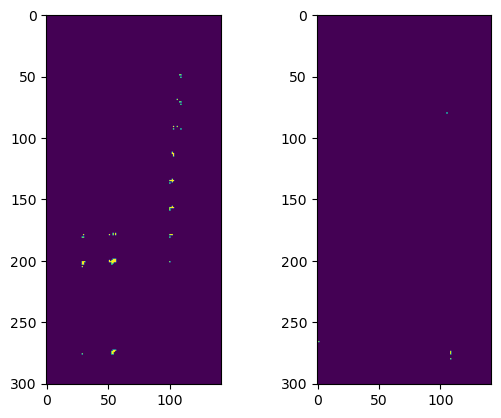

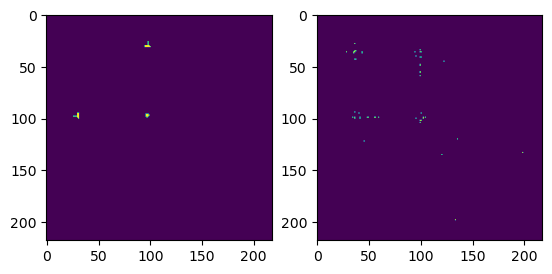

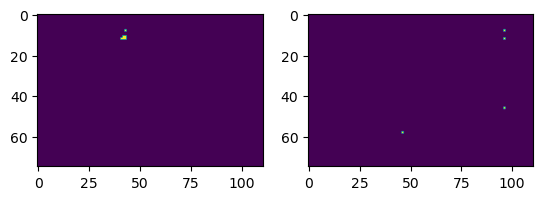

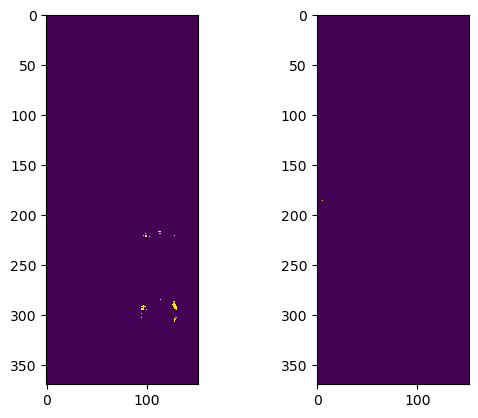

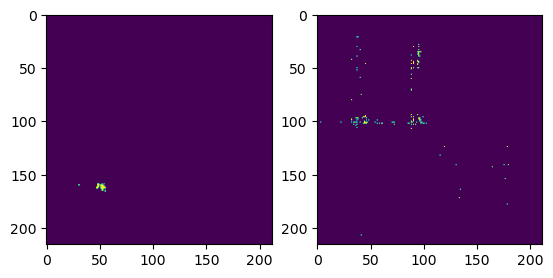

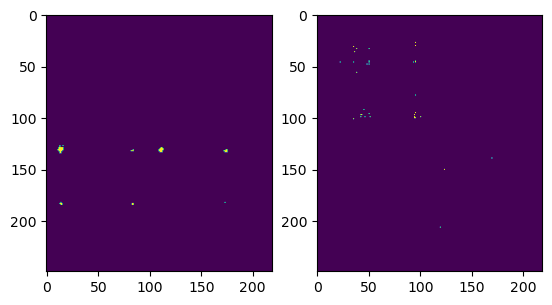

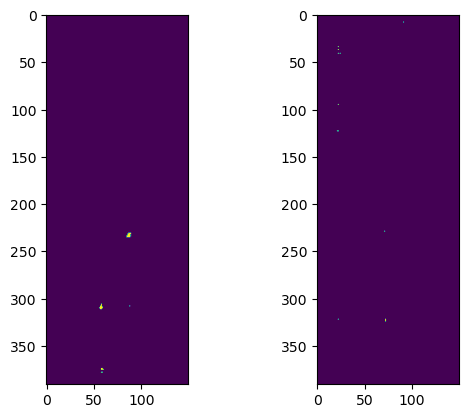

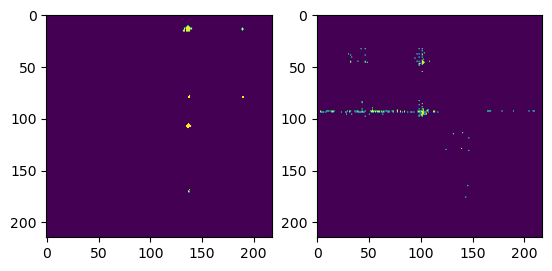

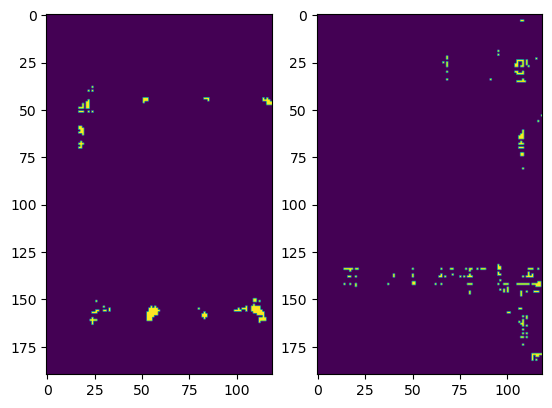

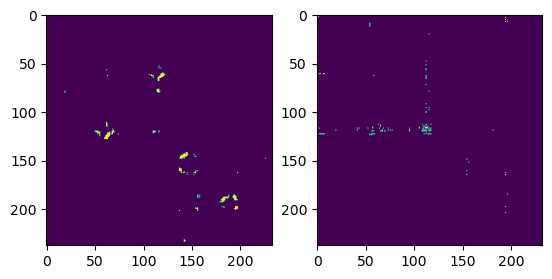

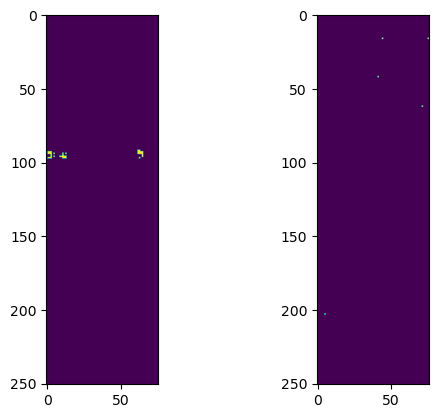

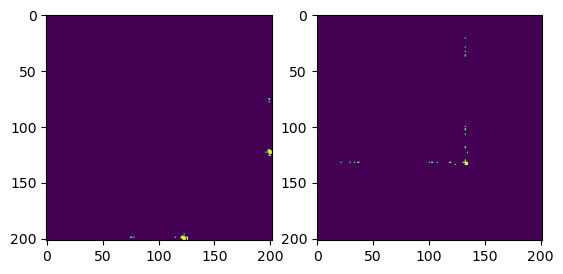

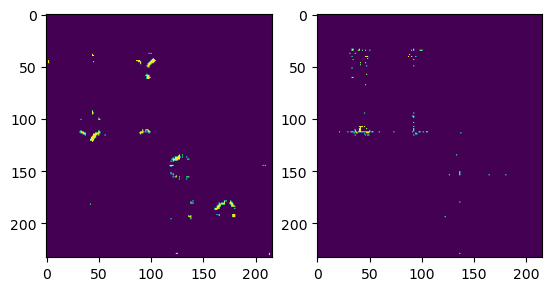

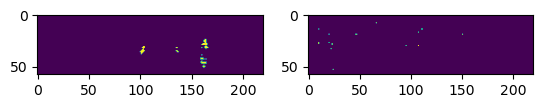

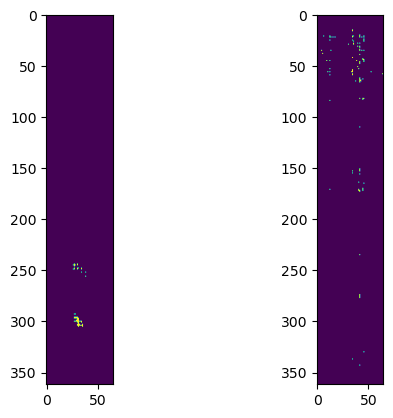

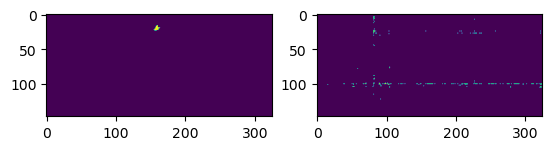

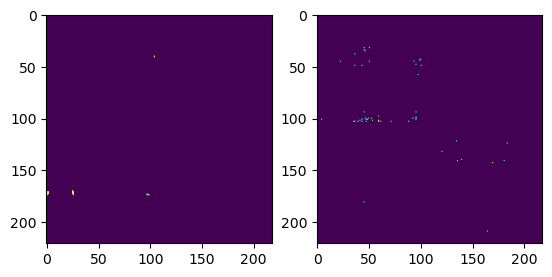

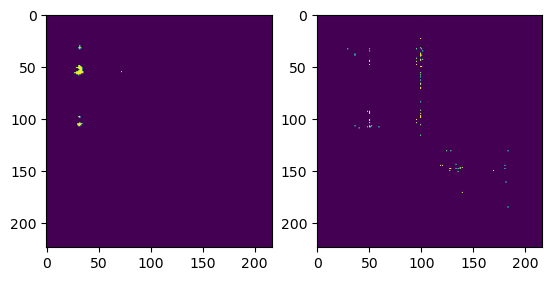

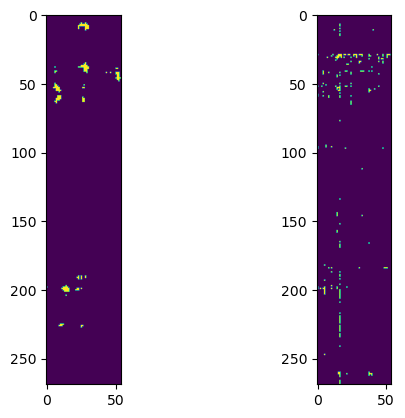

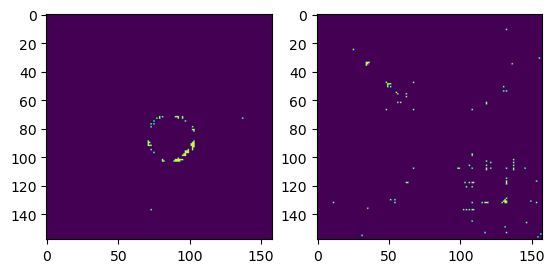

In [37]:
thres = 10
for t, p in zip(true_imgs, pred_imgs):
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(t < thres)
    ax[1].imshow(p < 15)

## Trained on 200 epochs

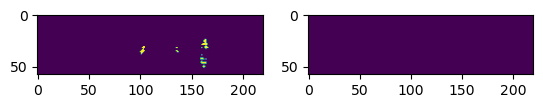

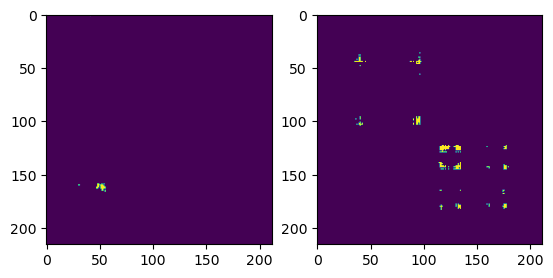

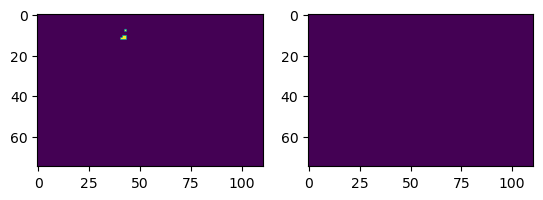

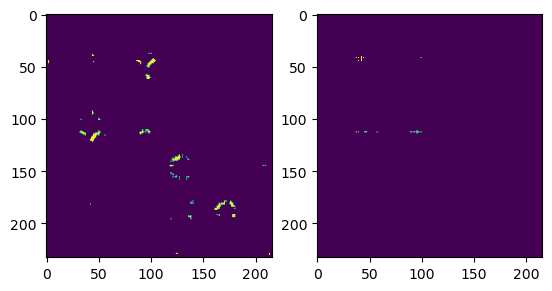

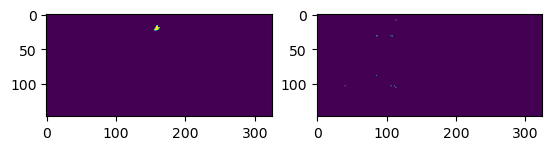

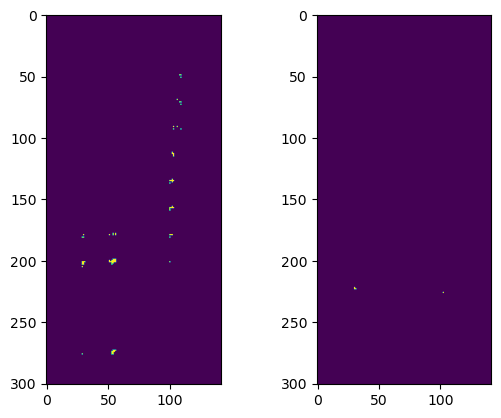

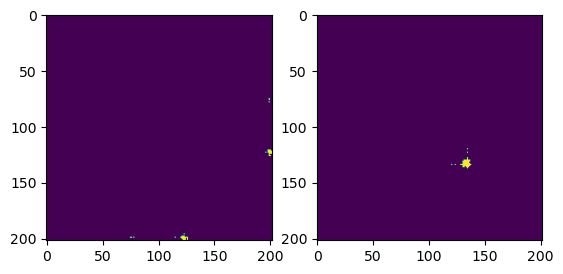

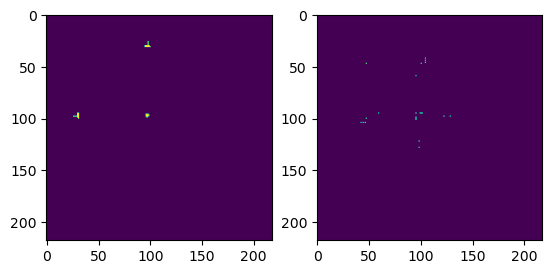

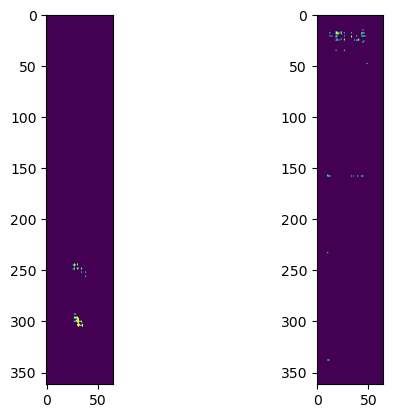

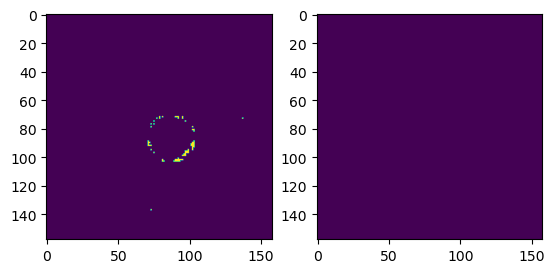

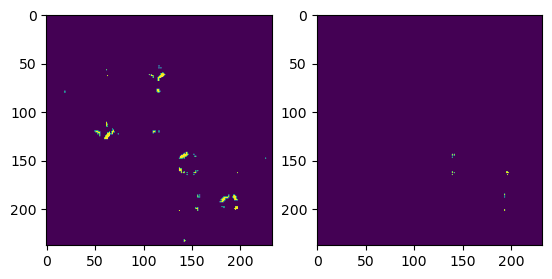

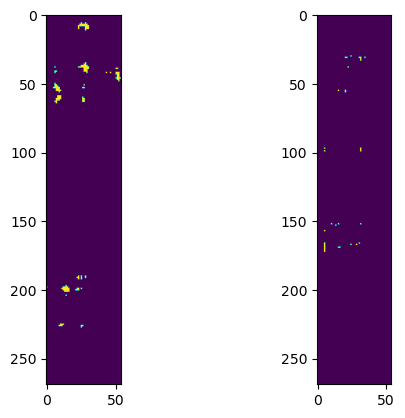

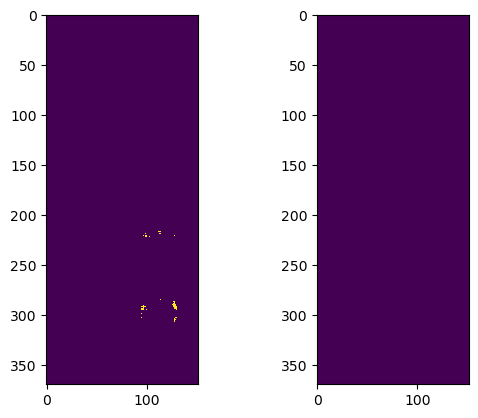

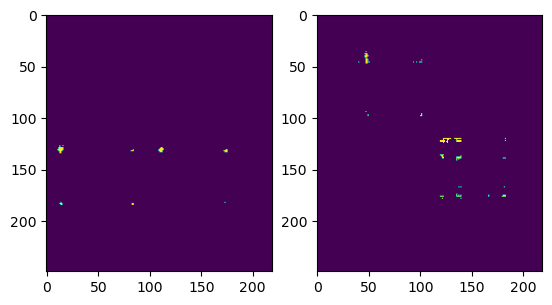

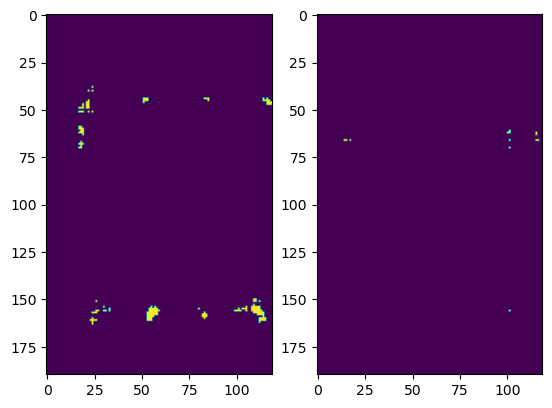

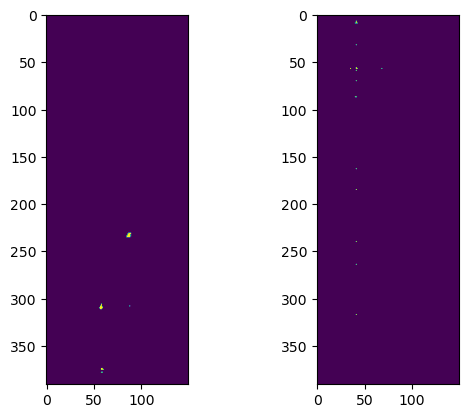

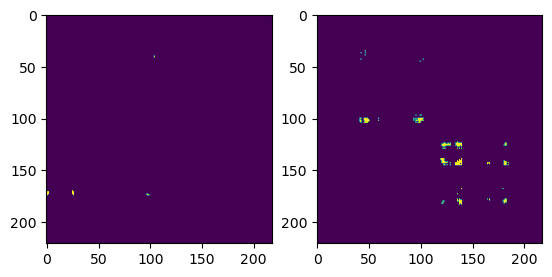

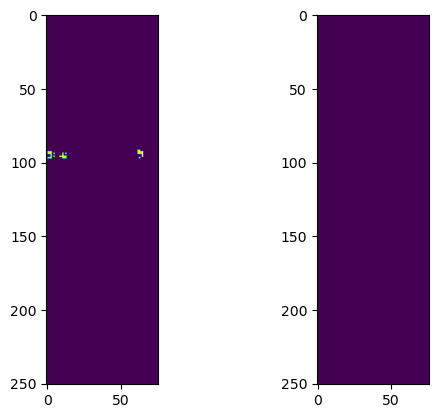

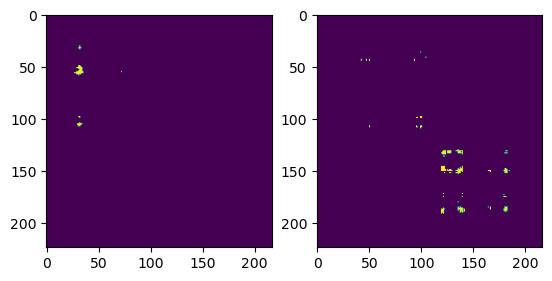

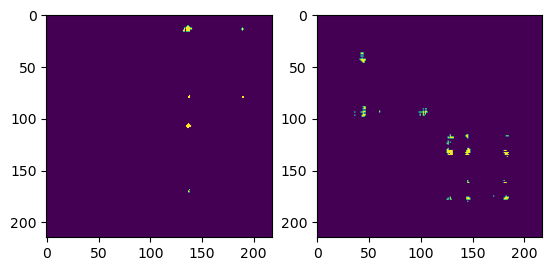

In [44]:
thres = 10
for t, p in zip(true_imgs, pred_imgs):
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(t < thres)
    ax[1].imshow(p < 15)